# Forecasting Emergency Events in Seattle

Welcome to my capstone project for [The Data Incubator](https://www.thedataincubator.com/)!

This project aims to use [real-time data](https://data.seattle.gov/Public-Safety/Seattle-Real-Time-Fire-911-Calls/kzjm-xkqj) provided by the [Seattle Fire Department](http://www.seattle.gov/fire/) to forecast upcoming "hotspots" (areas of high spatial intensity) for emergency calls (separately for fire and medical).

In the background, I'll make use of Random Fourier Feature Expansions of [Gaussian Process Priors](http://www.gaussianprocess.org/gpml/) to model the observed spatiotemporal point processes as deriving from a latent [Poisson intensity surface](https://en.wikipedia.org/wiki/Poisson_point_process); the brunt of the work is in discovering optimal hyperparameters for this meta-model.

My tool set is [R](https://cran.r-project.org/), especially [`data.table`](https://github.com/Rdatatable/data.table) for high-performance data manipulation, [`splancs`](https://cran.r-project.org/web/packages/splancs/index.html) for high-performance two-dimensional kernel density estimation, and [`spatstat`](http://spatstat.org/) for high-performance geospatial aggregation; and [`Vowpal Wabbit (VW)`](http://hunch.net/~vw/) for ultra-high-performance large-scale machine-learned Poisson regression.

This project is inspired by work forecasting crime hotspots in Portland for the [NIJ Real-Time Forecasting Challenge](https://www.nij.gov/funding/Pages/fy16-crime-forecasting-challenge.aspx), code for which is stored [here](https://github.com/MichaelChirico/portland).

In [ ]:
library(data.table)
library(sp)
library(rgeos)
library(rgdal)
library(animation)
library(akima)
library(fields)
library(viridis)

nine11 = fread('fire.csv')
nine11[ , date := as.POSIXct(date)]
seattle = readOGR('data', 'Neighborhoods')
seattle@data = setDT(seattle@data)

nine11SP = SpatialPointsDataFrame(
  nine11[ , cbind(x_lon, y_lat)], data = nine11,
  proj4string = seattle@proj4string
)
nine11SP$nbhd = (nine11SP %over% seattle)$OBJECTID
nine11[ , nbhd := nine11SP$nbhd]

seattle@data = 
  seattle@data[dcast(nine11, nbhd ~ category + pd_no, 
                     fun.aggregate = length, value.var = 'category'),
               on = c(OBJECTID = 'nbhd')]

ff = list.files('scores', pattern = 'fire', full.names = TRUE)
pspace = rbindlist(lapply(ff, fread))

In [77]:
#Visualization Number One: 
# GIF of hotspots by neighborhood
cols = colorRampPalette(c('white', 'red'))(6L)
col_cuts = c(0, 1, 11, 26, 51, 101)
colorize = function(nn) cols[findInterval(nn, col_cuts)]
pretty_date = 
  nine11[ , .(full_date = format(min(date), '%B %d, %Y')), 
          keyby = .(pd_no, yr, wk)]
plot_pd = function(period, categ)
  plot(seattle, col = colorize(seattle[[paste0(categ, '_', period)]]),
       main = paste0('Fire Alerts to 911 in Seattle\n',
                     'Week of ', pretty_date[.(period), full_date]))
#pick all the period numbers in the past year
now = Sys.Date()
past_year =
  pretty_date[pd_no >= pd_no[yr == year(now) - 1L & wk == week(now)], pd_no]
saveGIF(for (ii in past_year) plot_pd(ii, 'fire'), 'fire_911.gif')

Executing: 
convert -loop 0 -delay 100 Rplot1.png Rplot2.png Rplot3.png Rplot4.png
    Rplot5.png Rplot6.png Rplot7.png Rplot8.png Rplot9.png Rplot10.png
    Rplot11.png Rplot12.png Rplot13.png Rplot14.png Rplot15.png
    Rplot16.png Rplot17.png Rplot18.png Rplot19.png Rplot20.png
    Rplot21.png Rplot22.png Rplot23.png Rplot24.png Rplot25.png
    Rplot26.png Rplot27.png Rplot28.png Rplot29.png Rplot30.png
    Rplot31.png Rplot32.png Rplot33.png Rplot34.png Rplot35.png
    Rplot36.png Rplot37.png Rplot38.png Rplot39.png Rplot40.png
    Rplot41.png Rplot42.png Rplot43.png Rplot44.png Rplot45.png
    Rplot46.png Rplot47.png Rplot48.png Rplot49.png 'fire_911.gif'
Output at: fire_911.gif


[1] TRUE

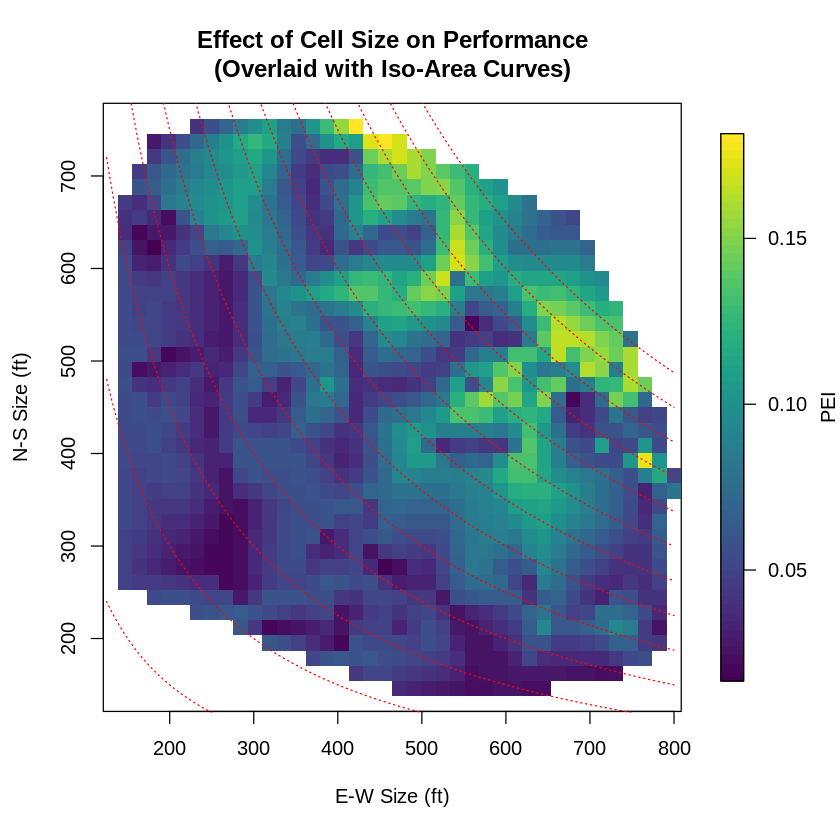

In [52]:
#Visualization Number Two:
#  Illustrating the Hyperparameter Performance Surface
invisible({
    pspace[pei > 0, image.plot(interp(delx, dely, pei, duplicate = 'mean'),
                              main = paste0('Effect of Cell Size on Performance\n',
                                            '(Overlaid with Iso-Area Curves)'),
                              xlab = 'E-W Size (ft)', ylab = 'N-S Size (ft)',
                              col = viridis(64), 
                              legend.lab = 'PEI', legend.line = 3)]
    })
xx = seq(125, 800, length.out = 1000)
for (AA in 30000 * (1:13)) {
    lines(xx, AA/xx, col = 'red', lty = 3)
}

In [51]:
#Visualization Number Three:
#  Implied Intensity Surface at Current Optimum